# FER - Facial Emotion Recognition

Workflow followed will be: -
1. Data Exploration
2. Data Preprocessing
3. Modelling
4. Evaluation
5. Performance
6. Deployment

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from random import shuffle
import pickle
import os

In [45]:
train_df = pd.read_csv('fer_dataset/train/_classes.csv')
train_df.head()

,filename,anger,contempt,disgust,fear,happy,sadness,surprise
0,S086_001_00000018_png.rf.418d54a16c078ac6027aa...,0,0,0,0,0,0,1
1,S086_002_00000015_png.rf.41d7a86060b5bf31f76cc...,0,0,0,0,1,0,0
2,S098_004_00000015_png.rf.4270b1a9d4a4f35906d1d...,0,0,0,0,1,0,0
3,S138_004_00000011_png.rf.4129c74a3961a6173bc7f...,0,0,0,0,0,0,1
4,S062_005_00000028_png.rf.413672dd0a90acbaee285...,0,0,1,0,0,0,0


In [46]:
from matplotlib.image import imread

Text(0.5, 1.0, ' sadness')

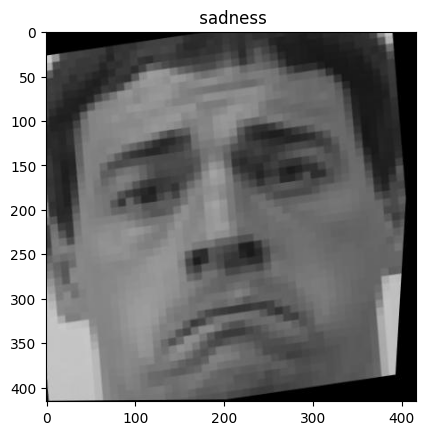

In [47]:
# Display one image
image_path = 'fer_dataset/train/S506_006_00000040_png.rf.9901171b6048534ac9fbc352c5ed4fc5.jpg'
img = imread(image_path)
image_name = image_path[image_path.rindex('/')+1:]
image_class = ""
response = train_df.loc[train_df['filename'] == image_name]
row_index = response.index

for col in response.columns:
    if (response[col] == 1)[1841]:
        image_class = col

plt.imshow(img)
plt.title(image_class)

In [48]:
train_df.shape

(2058, 8)

In [49]:
from random import randint

In [50]:
# Create a function to get a random image display it and its class

def random_image():
    row_index = randint(0, train_df.shape[0])
    response = train_df.loc[randint(0, train_df.shape[0])]
    image_name = response['filename']
    image_class = ""

    for col in response.index:
        if (response[col] == 1):
            image_class = col
            break
    
    img_path = 'fer_dataset/train/' + image_name
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    equ_img = cv2.equalizeHist(img)
    
    fig, axs = plt.subplots(2)
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(img, cmap='gray')
    axs[0].set_title(image_class)
    axs[1].set_title(f"{image_class} equalised")

    return equ_img

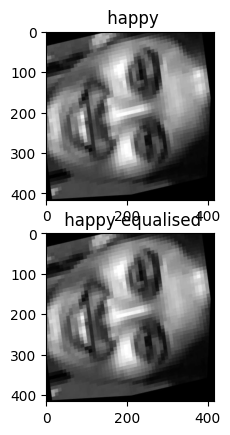

In [51]:
rand_img = random_image()

## 2. Data Preprocessing

In [17]:
TRAIN_DIR = 'fer_dataset/train'
VALID_DIR = 'fer_dataset/valid'
TEST_DIR = 'fer_dataset/test'

IMG_SIZE = (100, 100)

In [20]:
def get_data(dir, write_to, df_path):
    data = []
    df = pd.read_csv(df_path)
    for img in os.listdir(dir):
        label = df[df['filename'] == img]
        label = label.iloc[:, 1:].to_numpy()

        path = os.path.join(dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        data.append([np.array(img), np.array(label)])

    shuffle(data)

    with open(write_to, 'wb') as file:
        pickle.dump(data, file)
    
    return data

In [21]:
train_data = get_data(TRAIN_DIR, 'train_data1.pkl', 'fer_dataset/train/_classes.csv')
valid_data = get_data(VALID_DIR, 'valid_data1.pkl', 'fer_dataset/valid/_classes.csv')
test_data = get_data(TEST_DIR, 'test_data1.pkl', 'fer_dataset/test/_classes.csv')

## 3. Modelling

### 3.1 Reading in our data

In [26]:
with open('processed_data/train_data.pkl', 'rb') as file:
    train_data = pickle.load(file)

with open('processed_data/valid_data.pkl', 'rb') as file:
    valid_data = pickle.load(file)

with open('processed_data/test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [27]:
x_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])

x_validate = np.array([item[0] for item in valid_data])
y_validate = np.array([item[1] for item in valid_data])

x_test = np.array([item[0] for item in test_data])
y_test = np.array([item[1] for item in test_data])

In [28]:
x_train.shape, y_train.shape, x_validate.shape, y_validate.shape, x_test.shape, y_test.shape

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_validate = x_validate.reshape(x_validate.shape[0], x_validate.shape[1], x_validate.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])
y_validate = y_validate.reshape(y_validate.shape[0], y_validate.shape[2])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])

x_train.shape, y_train.shape, x_validate.shape, y_validate.shape, x_test.shape, y_test.shape

((2058, 100, 100, 1),
 (2058, 7),
 (196, 100, 100, 1),
 (196, 7),
 (99, 100, 100, 1),
 (99, 7))

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [32]:
# Define the model
model = keras.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),

    # Flatten the output
    layers.Flatten(),

    # Dense (fully connected) layers
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 output classes for emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.fit(x_train, y_train, epochs=10, validation_data=(x_validate, y_validate))

Epoch 1/10
65/65 [==============================] - 5s 74ms/step - loss: 8.8286 - accuracy: 0.2906 - val_loss: 1.6193 - val_accuracy: 0.4439
Epoch 2/10
65/65 [==============================] - 5s 77ms/step - loss: 1.5098 - accuracy: 0.4378 - val_loss: 1.4456 - val_accuracy: 0.4796
Epoch 3/10
65/65 [==============================] - 5s 73ms/step - loss: 1.1997 - accuracy: 0.5505 - val_loss: 1.4421 - val_accuracy: 0.4031
Epoch 4/10
65/65 [==============================] - 5s 74ms/step - loss: 0.9492 - accuracy: 0.6540 - val_loss: 1.5692 - val_accuracy: 0.4286
Epoch 5/10
65/65 [==============================] - 5s 74ms/step - loss: 0.6563 - accuracy: 0.7648 - val_loss: 1.5487 - val_accuracy: 0.4796
Epoch 6/10
65/65 [==============================] - 5s 79ms/step - loss: 0.4278 - accuracy: 0.8586 - val_loss: 1.7645 - val_accuracy: 0.4694
Epoch 7/10
65/65 [==============================] - 5s 75ms/step - loss: 0.2611 - accuracy: 0.9130 - val_loss: 1.8520 - val_accuracy: 0.4592
Epoch 8/10
65

In [94]:
# Saving model

model_path = 'fer_model'
tf.keras.models.save_model(model, model_path)

INFO:tensorflow:Assets written to: fer_model/assets


INFO:tensorflow:Assets written to: fer_model/assets


# Loading in our model and using it

In [96]:
# Loading in model
model_path = 'fer_model'

model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 28224)            

In [97]:
predicted_probs = model.predict(x_test)

4/4 [==============================] - 0s 15ms/step


In [98]:
class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
class_labels_encoded = {'anger':0, 'contempt':1, 'disgust':2, 'fear':3, 'happy':4, 'sadness':5, 'surprise':6}
encoded_val = 0

class_labels, class_labels_encoded

(['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'],
 {'anger': 0,
  'contempt': 1,
  'disgust': 2,
  'fear': 3,
  'happy': 4,
  'sadness': 5,
  'surprise': 6})

In [99]:
predicted_classes = np.argmax(predicted_probs,axis=1)
predicted_labels = [class_labels[i] for i in predicted_classes]

true_classes = np.argmax(y_test,axis=1)
true_labels = [class_labels[i] for i in true_classes]

for i in range(0, 10):
    print(f"Sample {i + 1}: Actual Label: {true_labels[i]}, Predicted Class Label: {predicted_labels[i]}, Predicted Probability: {predicted_probs[i, predicted_classes[i]]:.2%}")

Sample 1: Actual Label: anger, Predicted Class Label: anger, Predicted Probability: 84.43%
Sample 2: Actual Label: contempt, Predicted Class Label: sadness, Predicted Probability: 46.16%
Sample 3: Actual Label: anger, Predicted Class Label: disgust, Predicted Probability: 100.00%
Sample 4: Actual Label: surprise, Predicted Class Label: surprise, Predicted Probability: 99.13%
Sample 5: Actual Label: happy, Predicted Class Label: happy, Predicted Probability: 56.10%
Sample 6: Actual Label: anger, Predicted Class Label: disgust, Predicted Probability: 72.37%
Sample 7: Actual Label: anger, Predicted Class Label: disgust, Predicted Probability: 99.81%
Sample 8: Actual Label: happy, Predicted Class Label: happy, Predicted Probability: 92.02%
Sample 9: Actual Label: sadness, Predicted Class Label: sadness, Predicted Probability: 39.98%
Sample 10: Actual Label: disgust, Predicted Class Label: disgust, Predicted Probability: 88.33%


In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [101]:
import seaborn as sns

In [102]:
def performance_evaluation(model, x, y):
    class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
    class_labels_encoded = {'anger':0, 'contempt':1, 'disgust':2, 'fear':3, 'happy':4, 'sadness':5, 'surprise':6}

    predicted_probs = model.predict(x)
    
    predicted_classes = np.argmax(predicted_probs,axis=1)
    predicted_labels = [class_labels[i] for i in predicted_classes]

    true_classes = np.argmax(y,axis=1)
    true_labels = [class_labels[i] for i in true_classes]

    encoded_predicted = [class_labels_encoded[i] for i in predicted_labels]
    encoded_true = [class_labels_encoded[i] for i in true_labels]

    accuracy = accuracy_score(encoded_true, encoded_predicted)
    precision = precision_score(encoded_true, encoded_predicted, average='macro')
    recall = recall_score(encoded_true, encoded_predicted, average='macro')
    cm = confusion_matrix(encoded_true, encoded_predicted)

    print(f"Accuracy Score: {accuracy}")
    print(f"Precision Score per class: {precision}")
    print(f"Recall Score per class: {recall}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels_encoded.keys(), yticklabels=class_labels_encoded.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    

65/65 [==============================] - 1s 20ms/step
Accuracy Score: 0.9829931972789115
Precision Score per class: 0.9813105334939071
Recall Score per class: 0.9797187862546208


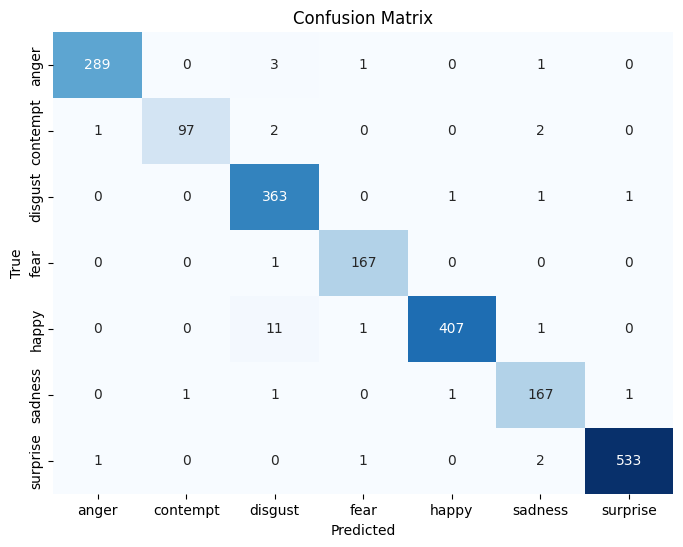

In [103]:
performance_evaluation(model, x_train, y_train)

4/4 [==============================] - 0s 26ms/step
Accuracy Score: 0.47474747474747475
Precision Score per class: 0.43945988651871
Recall Score per class: 0.3895485466914038


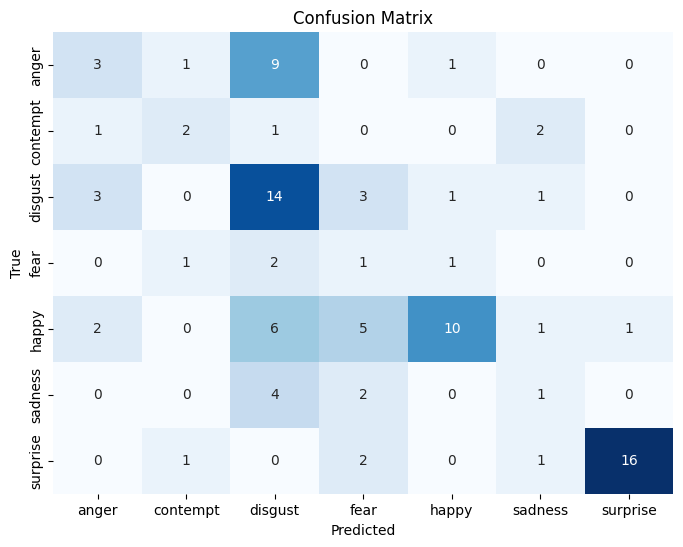

In [104]:
performance_evaluation(model, x_test, y_test)

## Checking on a test image

Text(0.5, 1.0, 'Test Image')

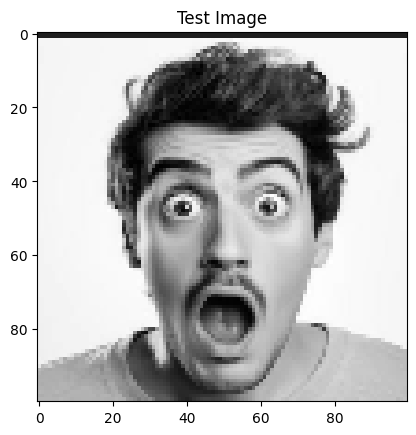

In [105]:
test_img = cv2.imread('test_img.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
test_img = cv2.resize(test_img, (100, 100))

plt.imshow(test_img, cmap='gray')
plt.title('Test Image')

In [106]:
test_img = test_img.reshape(1, 100, 100, 1)

In [107]:
x_train.shape, test_img.shape

((2058, 100, 100, 1), (1, 100, 100, 1))

In [108]:
predicted_prob_test = model.predict(test_img)

1/1 [==============================] - 0s 11ms/step


In [109]:
predicted_class_test = np.argmax(predicted_prob_test)
predicted_label_test = class_labels[predicted_class_test]
predicted_prob_test, predicted_label_test

(array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7098660e-30,
         6.2588714e-22, 0.0000000e+00, 1.0000000e+00]], dtype=float32),
 'surprise')

In [110]:
def predict_image_class(model, img):
    class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
    class_labels_encoded = {'anger':0, 'contempt':1, 'disgust':2, 'fear':3, 'happy':4, 'sadness':5, 'surprise':6}

    predicted_probs = model.predict(img)
    predicted_class = np.argmax(predicted_prob_test)
    predicted_label = class_labels[predicted_class_test]

    img_new = img.reshape(100, 100)
    plt.imshow(img_new, cmap='gray')
    plt.title(f'Class: {predicted_label}, Probability: {np.max(predicted_probs):.2%}')

1/1 [==============================] - 0s 21ms/step


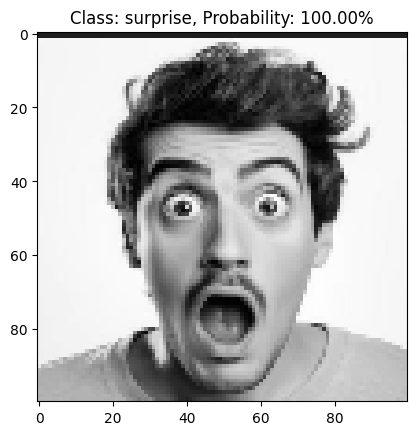

In [111]:
predict_image_class(model, test_img)